# Analysing features of Latence Tech dataset

In [4]:
import numpy as np 
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy import interpolate
import pytz



In [5]:
data = pd.read_csv("/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/data/Latence_tech/participant_data.csv")
data = data.iloc[::-1].reset_index(drop=True)
data.head(5)

,id,_time,agentID,Altitude,Latitude,Longitude,http_result,icmp_result,tcp_result,udp_result
0,1934,2024-09-16 17:13:19+00:00,752813491,18.823519,45.496026,-73.561997,13.619,21.588,13.488,21.570
1,1933,2024-09-16 17:13:21+00:00,752813491,18.823519,45.496026,-73.561997,11.645,12.584,13.018,17.155
2,1932,2024-09-16 17:13:23+00:00,752813491,18.823519,45.496026,-73.561997,14.019,17.161,14.217,24.523
3,1931,2024-09-16 17:13:25+00:00,752813491,18.823519,45.496026,-73.561997,22.238,12.144,12.141,20.624
4,1930,2024-09-16 17:13:27+00:00,752813491,18.823519,45.496026,-73.561997,12.473,11.588,12.961,14.024


Handling NaN values

In [6]:
data_clean = data.dropna(axis=0)
data_clean.head(5)

,id,_time,agentID,Altitude,Latitude,Longitude,http_result,icmp_result,tcp_result,udp_result
0,1934,2024-09-16 17:13:19+00:00,752813491,18.823519,45.496026,-73.561997,13.619,21.588,13.488,21.570
1,1933,2024-09-16 17:13:21+00:00,752813491,18.823519,45.496026,-73.561997,11.645,12.584,13.018,17.155
2,1932,2024-09-16 17:13:23+00:00,752813491,18.823519,45.496026,-73.561997,14.019,17.161,14.217,24.523
3,1931,2024-09-16 17:13:25+00:00,752813491,18.823519,45.496026,-73.561997,22.238,12.144,12.141,20.624
4,1930,2024-09-16 17:13:27+00:00,752813491,18.823519,45.496026,-73.561997,12.473,11.588,12.961,14.024


In [7]:
data_clean['_time'] = pd.to_datetime(data_clean['_time'])
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 0 to 1934
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   id           1615 non-null   int64              
 1   _time        1615 non-null   datetime64[ns, UTC]
 2   agentID      1615 non-null   int64              
 3   Altitude     1615 non-null   float64            
 4   Latitude     1615 non-null   float64            
 5   Longitude    1615 non-null   float64            
 6   http_result  1615 non-null   float64            
 7   icmp_result  1615 non-null   float64            
 8   tcp_result   1615 non-null   float64            
 9   udp_result   1615 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(2)
memory usage: 138.8 KB


/var/folders/0c/shtsn4rd7wgcpfmwpnvvgzh80000gn/T/ipykernel_34501/2455822655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['_time'] = pd.to_datetime(data_clean['_time'])


Adding **seconds** feature

In [8]:
# Specify the timezone
timezone = pytz.utc
start_time = datetime(2024, 9, 16, 0, 0, 0, tzinfo=timezone)

data_clean.loc[:,'_time'] = pd.to_datetime(data_clean['_time'])
data_clean.loc[:,'seconds'] = (data_clean['_time'] - start_time).dt.total_seconds().astype(int)
# data_clean['seconds'] = data_clean['_time'].dt.hour * 3600 + data_clean['_time'].dt.minute * 60 + data_clean['_time'].dt.second #(data_clean['_time'] - reference_datetime).dt.total_seconds()
print(data_clean['seconds'])

0        61999
1        62001
2        62003
3        62005
4        62007
         ...  
1930    407937
1931    407939
1932    407941
1933    407943
1934    407945
Name: seconds, Length: 1615, dtype: int64


/var/folders/0c/shtsn4rd7wgcpfmwpnvvgzh80000gn/T/ipykernel_34501/3422130382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:,'seconds'] = (data_clean['_time'] - start_time).dt.total_seconds().astype(int)


## Feature Engineering

In [9]:
# Assume you have a DataFrame 'data' with a 'timestamp' and 'latency' column
# 1. Temporal features
# data_clean['hour'] = data_clean['timestamp'].dt.hour
# data_clean['minute'] = data_clean['timestamp'].dt.minute
# data_clean['seconds'] = data_clean['_time'].dt.hour * 3600 + data_clean['_time'].dt.minute * 60 + data_clean['_time'].dt.second #(data_clean['_time'] - reference_datetime).dt.total_seconds()
# print(data_clean['seconds'])
# data_clean['elapsed_time'] = (data_clean['timestamp'] - data_clean['timestamp'].min()).dt.total_seconds()

In [10]:
latencies = ['http_result', 'icmp_result','tcp_result', 'udp_result']

for lt in latencies: 
    mask = data_clean[lt].notna()
    curr = data_clean[lt][0] 
    data_clean[lt + '_lag_1'] = data_clean[lt].shift(1).where(mask)   
    data_clean[lt + '_lag_1'][0] = curr
 # data_clean[lt + '_lag_2'] = data_clean[lt].shift(-2, fill_value=0)

print(data_clean['http_result_lag_1'])

0       13.619
1       13.619
2       11.645
3       14.019
4       22.238
         ...  
1930    34.133
1931    39.228
1932    30.057
1933    33.209
1934    29.955
Name: http_result_lag_1, Length: 1615, dtype: float64


/var/folders/0c/shtsn4rd7wgcpfmwpnvvgzh80000gn/T/ipykernel_34501/2982110746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[lt + '_lag_1'] = data_clean[lt].shift(1).where(mask)
/var/folders/0c/shtsn4rd7wgcpfmwpnvvgzh80000gn/T/ipykernel_34501/2982110746.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, lik

In [11]:
# # 3. Rolling statistics
# for lt in latencies:
#     data_clean[lt+'_rolling_mean_5'] = data_clean[lt].rolling(window=5).mean()
#     data_clean[lt+'_rolling_std_10'] = data_clean[lt].rolling(window=10).std()


In [12]:

# # 4. Rate of change
# for lt in latencies:
#     data_clean[f'delta_{lt}'] = data_clean[lt] - data_clean[lt+'_lag_1']


### Adding temperature 

In [13]:
temp = pd.read_csv('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/data/Latence_tech/weather.csv')
temp.head(5)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-09-16 00:00:00,21,15.3,70,0.0,NaN,193,8.6,NaN,1024.9,NaN,1
1,2024-09-16 01:00:00,22,14.6,63,0.0,NaN,188,8.6,NaN,1024.7,NaN,1
2,2024-09-16 02:00:00,21,14.4,66,0.0,NaN,200,4.0,NaN,1024.7,NaN,1
3,2024-09-16 03:00:00,21,14.6,67,0.0,NaN,237,7.9,NaN,1024.8,NaN,1
4,2024-09-16 04:00:00,19,14.9,77,0.0,NaN,220,8.3,NaN,1024.5,NaN,1


In [14]:
temp['time'] = pd.to_datetime(temp['time'])
temp.loc[:,'hour'] = temp['time'].dt.hour
temp_clean = temp[['hour', 'temp']]

In [15]:
temp_16 = temp_clean[0:24].values # for 16 septembre
temp_20 = temp_clean[-24:].values # for 20 septembre

In [16]:
new_times = np.linspace(0,23, num = 23*60*60)

hours = np.arange(0,24,1)

temperature_16 = temp_16[:,1]
temperature_20 = temp_20[:,1]
spline_interpolator_16 = interpolate.interp1d(hours, temperature_16, kind='cubic')
spline_interpolator_20 = interpolate.interp1d(hours, temperature_20, kind='cubic')

interpolated_spline_16 = spline_interpolator_16(new_times)
interpolated_spline_20 = spline_interpolator_20(new_times)

start_time = datetime(2024, 9, 16, 0, 0, 0)  # Example start date: September 16, 2024, 00:00:00
times_in_hhmmss_16 = [start_time + timedelta(seconds=int(t)) for t in new_times*60*60]
start_time = datetime(2024, 9, 20, 0, 0, 0)
times_in_hhmmss_20 = [start_time + timedelta(seconds=int(t)) for t in new_times*60*60]

new_times_sec = np.arange(0,23*60*60,1)
interpolated_df_16 = pd.DataFrame({
    'seconds': new_times_sec,
    # 'time': [time.strftime('%Y-%m-%d %H:%M:%S') for time in times_in_hhmmss_16],  # Format as hh:mm:ss
    'temp': interpolated_spline_16
})

interpolated_df_20 = pd.DataFrame({
    'seconds': new_times_sec + 4*24*60*60,
    # 'time': [time.strftime('%Y-%m-%d . %H:%M:%S') for time in times_in_hhmmss_20],  # Format as hh:mm:ss
    'temp': interpolated_spline_20
})

Visualisation 

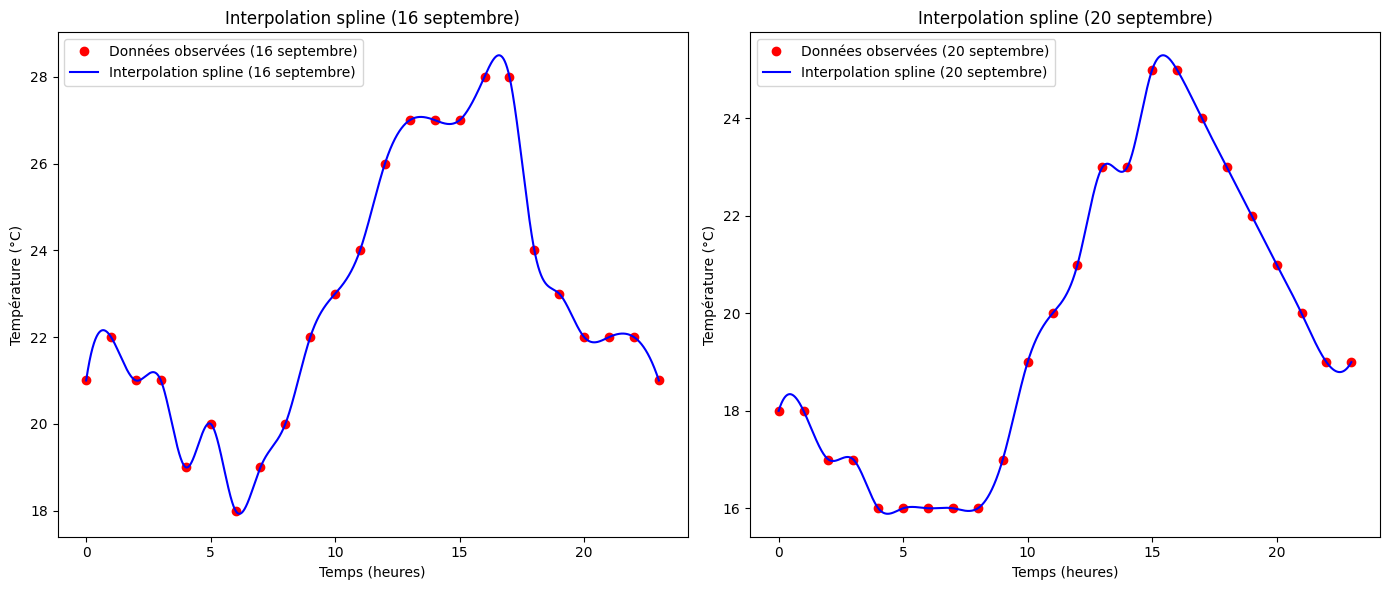

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphique pour le 16 septembre
ax1.plot(hours, temperature_16, 'o', label='Données observées (16 septembre)', color='red')
ax1.plot(new_times, interpolated_spline_16, '-', label='Interpolation spline (16 septembre)', color='blue')
ax1.set_title('Interpolation spline (16 septembre)')
ax1.set_xlabel('Temps (heures)')
ax1.set_ylabel('Température (°C)')
ax1.legend()

# Graphique pour le 20 septembre
ax2.plot(hours, temperature_20, 'o', label='Données observées (20 septembre)', color='red')
ax2.plot(new_times, interpolated_spline_20, '-', label='Interpolation spline (20 septembre)', color='blue')
ax2.set_title('Interpolation spline (20 septembre)')
ax2.set_xlabel('Temps (heures)')
ax2.set_ylabel('Température (°C)')
ax2.legend()

# Afficher la figure avec les deux sous-graphiques
plt.tight_layout()
plt.show()

In [18]:
temp_whole = pd.concat((interpolated_df_16, interpolated_df_20), axis=0)

In [19]:
temp_whole

,seconds,temp
0,0,21.000000
1,1,21.001062
2,2,21.002123
3,3,21.003184
4,4,21.004244
...,...,...
82795,428395,18.998976
82796,428396,18.999232
82797,428397,18.999488
82798,428398,18.999744


In [40]:
data_temp = pd.merge(data_clean, 
                    temp_whole, 
                    on='seconds',
                    how='left')
data_temp

,id,_time,agentID,Altitude,Latitude,Longitude,http_result,icmp_result,tcp_result,udp_result,seconds,http_result_lag_1,icmp_result_lag_1,tcp_result_lag_1,udp_result_lag_1,temp
0,1934,2024-09-16 17:13:19+00:00,752813491,18.823519,45.496026,-73.561997,13.619,21.588,13.488,21.570,61999,13.619,21.588,13.488,21.570,27.262308
1,1933,2024-09-16 17:13:21+00:00,752813491,18.823519,45.496026,-73.561997,11.645,12.584,13.018,17.155,62001,13.619,21.588,13.488,21.570,27.260118
2,1932,2024-09-16 17:13:23+00:00,752813491,18.823519,45.496026,-73.561997,14.019,17.161,14.217,24.523,62003,11.645,12.584,13.018,17.155,27.257927
3,1931,2024-09-16 17:13:25+00:00,752813491,18.823519,45.496026,-73.561997,22.238,12.144,12.141,20.624,62005,14.019,17.161,14.217,24.523,27.255734
4,1930,2024-09-16 17:13:27+00:00,752813491,18.823519,45.496026,-73.561997,12.473,11.588,12.961,14.024,62007,22.238,12.144,12.141,20.624,27.253540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,4,2024-09-20 17:18:57+00:00,752813491,20.292809,45.496175,-73.561853,39.228,43.609,30.135,53.984,407937,34.133,35.945,30.996,44.054,23.677624
1611,3,2024-09-20 17:18:59+00:00,752813491,20.292809,45.496175,-73.561853,30.057,64.112,30.036,74.137,407939,39.228,43.609,30.135,53.984,23.677065
1612,2,2024-09-20 17:19:01+00:00,752813491,20.292809,45.496175,-73.561853,33.209,31.992,29.947,42.514,407941,30.057,64.112,30.036,74.137,23.676507
1613,1,2024-09-20 17:19:03+00:00,752813491,20.292809,45.496175,-73.561853,29.955,59.476,30.031,69.706,407943,33.209,31.992,29.947,42.514,23.675949


In [21]:
corr_matrix = (data_temp.drop(columns = ['_time','agentID','id'])).corr()


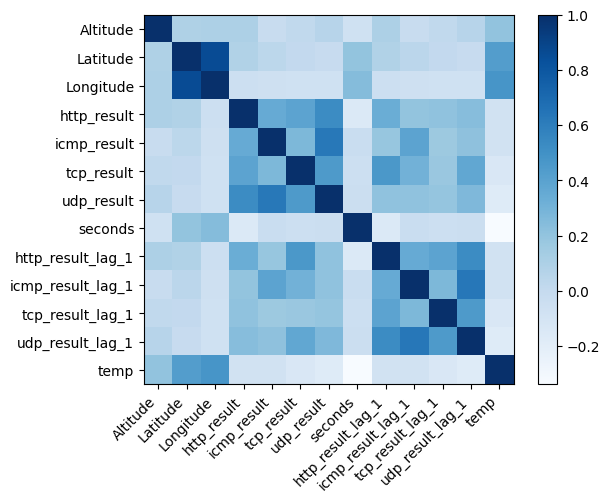

In [22]:
# plotting correlation matrix 
plt.imshow(corr_matrix, cmap='Blues') 
# adding colorbar 
plt.colorbar()
# extracting variable names 
variables = [] 
for i in corr_matrix.columns: 
    variables.append(i) 
# Adding labels to the matrix 
plt.xticks(range(len(corr_matrix)), variables, rotation=45, ha='right') 
plt.yticks(range(len(corr_matrix)), variables) 
# # Display the plot 
plt.show()

# Data Visualization

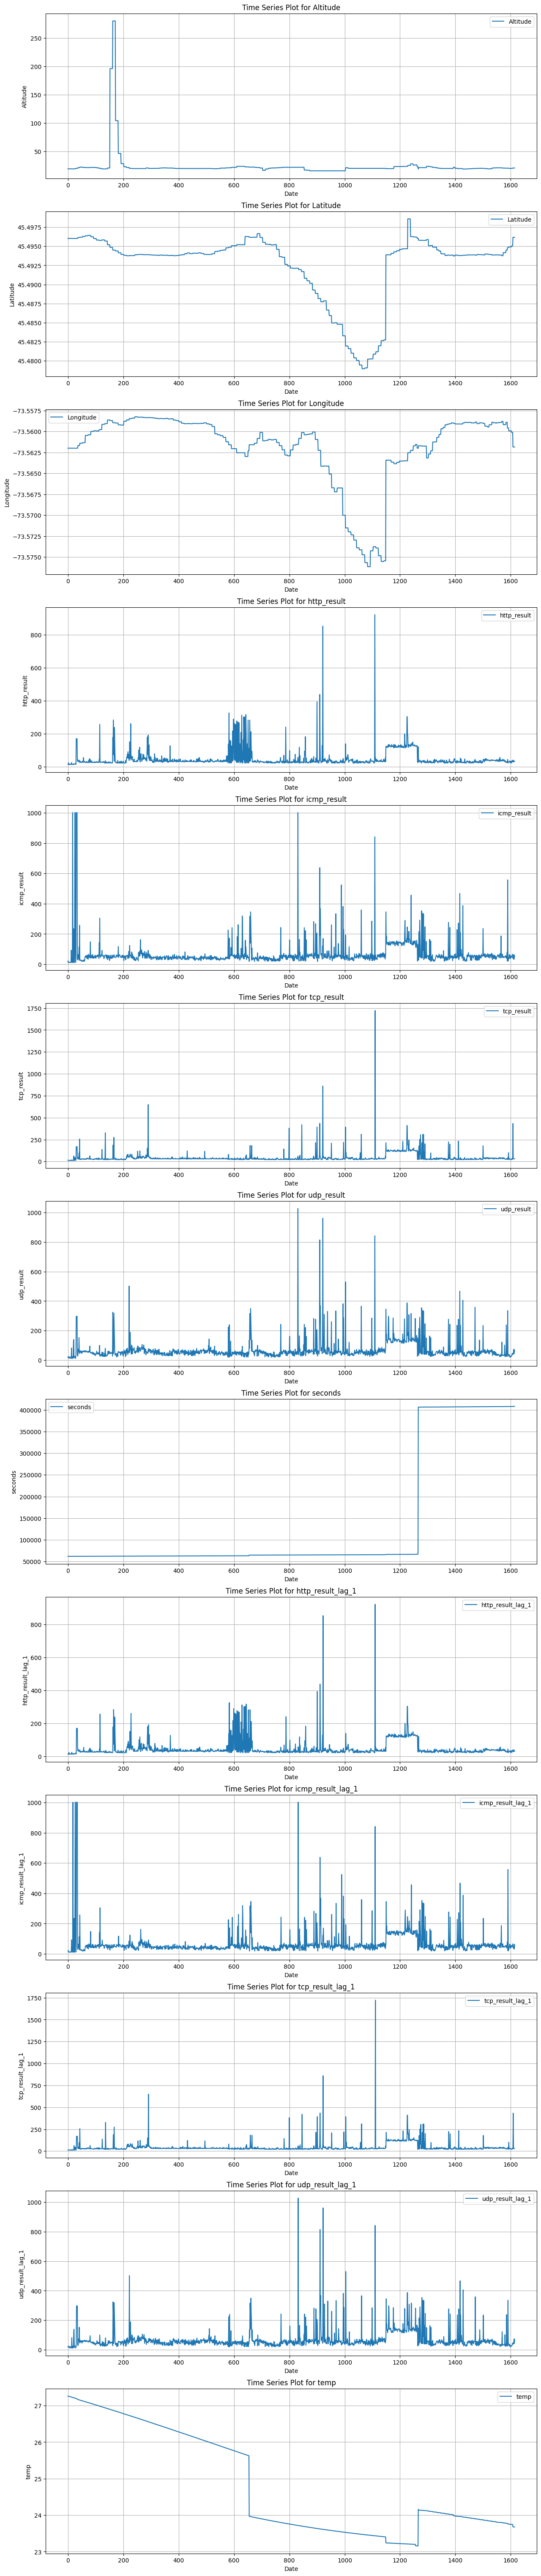

In [249]:
data_sarima = data_temp.drop(columns=['id','_time','agentID'])

# Set the size of the plots
plt.figure(figsize=(15, 6*len(data_sarima.columns)))

# Loop through each column in the DataFrame and plot
for i, col in enumerate(data_sarima.columns):
    plt.subplot(len(data_sarima.columns), 1, i + 1)  # Create a subplot for each variable
    plt.plot(data_sarima[col], label=col)
    plt.title(f'Time Series Plot for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid()

  # Adjust subplots to fit into figure area.
plt.show()


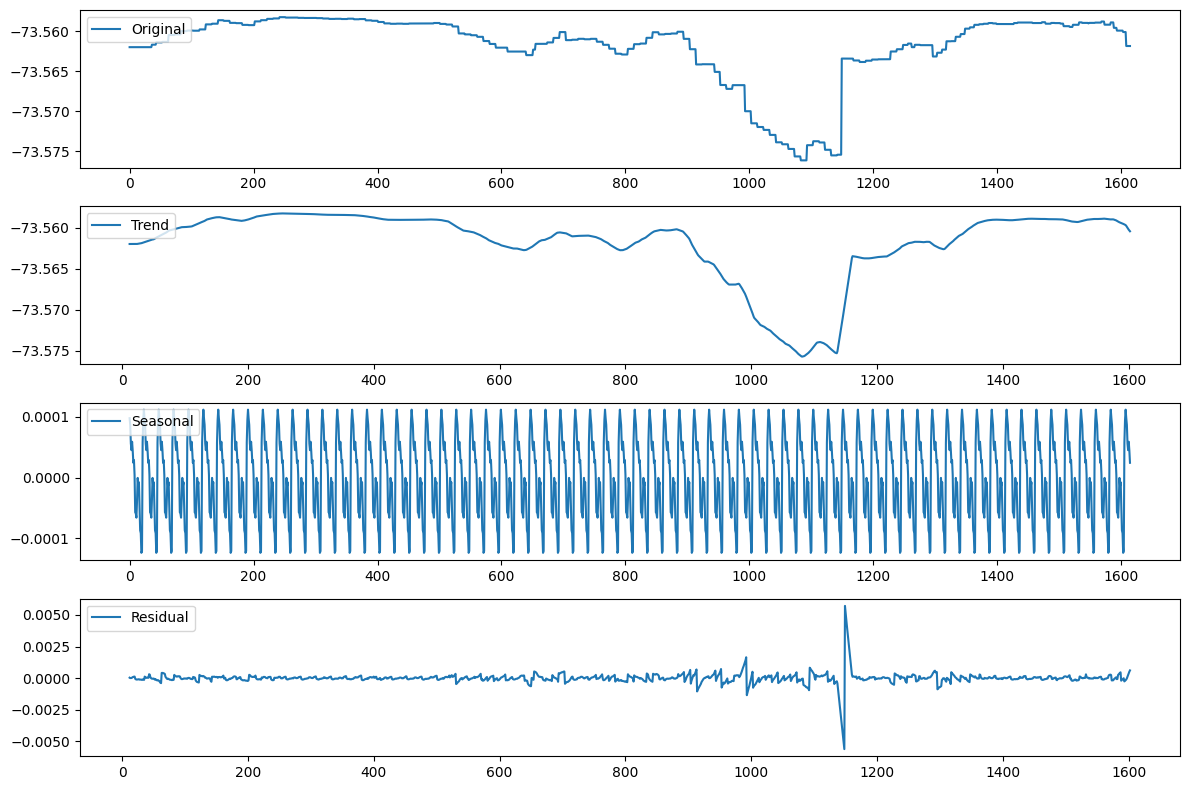

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Choose a variable to decompose
variable_to_decompose = data_sarima['Longitude']  # Replace with your variable name

# Perform seasonal decomposition
decomposition = seasonal_decompose(variable_to_decompose, model='additive', period=24)  # Adjust the period based on your data's frequency
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(variable_to_decompose, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


SCALING

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = data_clean.__deepcopy__()
minimum_val = min(data_clean['Latitude'])
data_scaled[['Latitude']] = (data_clean[['Latitude']] - minimum_val)*1000
minimum_val = min(data_clean['Altitude'])
data_scaled[['Altitude']] = (data_clean[['Altitude']] - minimum_val)*100
max_val_long = max(data_clean['Longitude'])
data_scaled[['Longitude']] = (data_clean[['Longitude']] - max_val_long)*1000
data_scaled.head(20)

,id,_time,agentID,Altitude,Latitude,Longitude,http_result,icmp_result,tcp_result,udp_result,seconds,http_result_lag_1,icmp_result_lag_1,tcp_result_lag_1,udp_result_lag_1
0,1934,2024-09-16 17:13:19+00:00,752813491,354.721260,17.081336,-3.750576,13.619,21.588,13.488,21.570,61999,13.619,21.588,13.488,21.570
1,1933,2024-09-16 17:13:21+00:00,752813491,354.721260,17.081336,-3.750576,11.645,12.584,13.018,17.155,62001,13.619,21.588,13.488,21.570
2,1932,2024-09-16 17:13:23+00:00,752813491,354.721260,17.081336,-3.750576,14.019,17.161,14.217,24.523,62003,11.645,12.584,13.018,17.155
3,1931,2024-09-16 17:13:25+00:00,752813491,354.721260,17.081336,-3.750576,22.238,12.144,12.141,20.624,62005,14.019,17.161,14.217,24.523
4,1930,2024-09-16 17:13:27+00:00,752813491,354.721260,17.081336,-3.750576,12.473,11.588,12.961,14.024,62007,22.238,12.144,12.141,20.624
5,1929,2024-09-16 17:13:29+00:00,752813491,354.721260,17.081336,-3.750576,13.521,11.912,11.731,13.707,62009,12.473,11.588,12.961,14.024
6,1928,2024-09-16 17:13:31+00:00,752813491,354.721260,17.081336,-3.750576,13.048,11.168,12.316,15.217,62011,13.521,11.912,11.731,13.707
7,1927,2024-09-16 17:13:33+00:00,752813491,354.721260,17.081336,-3.750576,12.491,12.563,11.546,21.904,62013,13.048,11.168,12.316,15.217
8,1926,2024-09-16 17:13:35+00:00,752813491,354.721260,17.081336,-3.750576,13.581,11.278,13.313,22.732,62015,12.491,12.563,11.546,21.904
9,1925,2024-09-16 17:13:37+00:00,752813491,353.424835,17.081336,-3.750576,12.609,13.224,11.766,14.457,62017,13.581,11.278,13.313,22.732


/var/folders/0c/shtsn4rd7wgcpfmwpnvvgzh80000gn/T/ipykernel_26610/2496687480.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


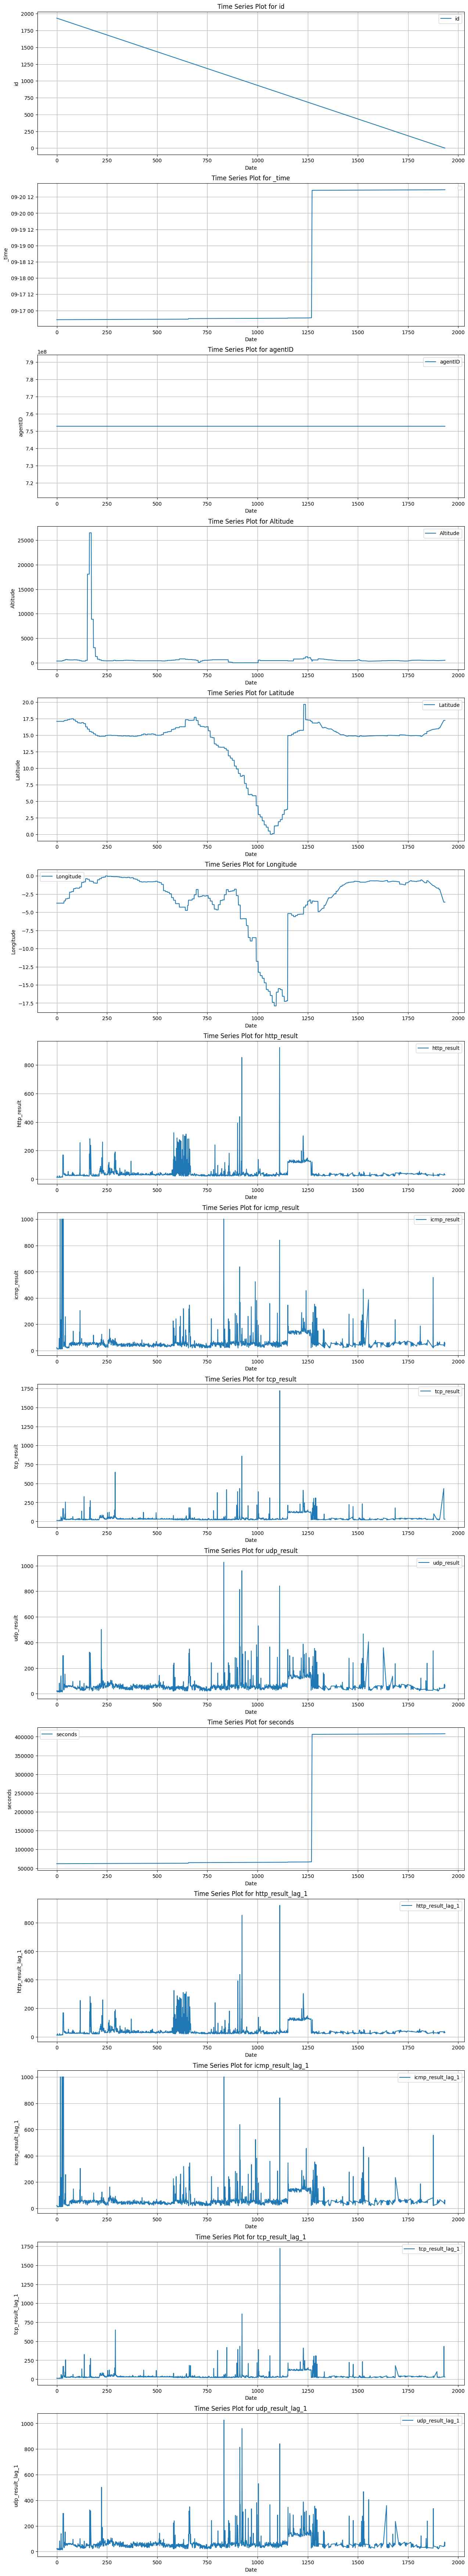

In [264]:
data_bla = data_scaled.drop(columns=['id','_time','agentID'])

# Set the size of the plots
plt.figure(figsize=(15, 6*len(data_scaled.columns)))

# Loop through each column in the DataFrame and plot
for i, col in enumerate(data_scaled.columns):
    plt.subplot(len(data_scaled.columns), 1, i + 1)  # Create a subplot for each variable
    plt.plot(data_scaled[col], label=col)
    plt.title(f'Time Series Plot for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid()

  # Adjust subplots to fit into figure area.
plt.show()


# Model Testing

SARIMA method

In [178]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
# def test_stationarity(timeseries):
#     # Perform ADF test
#     result = adfuller(timeseries)
#     print('ADF Statistic:', result[0])
#     print('p-value:', result[1])
#     return result[1]  # Return p-value

# data_sarima = data_temp.drop(columns=['id','_time','agentID'])
# # Check stationarity for each variable
# for col in data_temp.columns:
#     print(f"Checking stationarity for {col}:")
#     p_value = test_stationarity(data[col])
#     if p_value < 0.05:
#         print(f"{col} is stationary.")
#     else:
#         print(f"{col} is not stationary. Consider differencing.")


Dropping the variables that are non-stationary

In [ ]:
# # Example of differencing
# data_diff = data.diff().dropna()


Fit Model

In [ ]:
# # Define the SARIMA model parameters (p, d, q) x (P, D, Q, s)
# # You need to choose these parameters based on your data and experimentation
# p = 1  # AR order
# d = 1  # Differencing
# q = 1  # MA order
# P = 1  # Seasonal AR order
# D = 1  # Seasonal differencing
# Q = 1  # Seasonal MA order
# s = 12  # Seasonal period (e.g., 12 for monthly data)

# # Dictionary to store models and forecasts
# models = {}
# forecasts = {}

# for col in data.columns:
#     print(f"Fitting SARIMA model for {col}...")
#     model = SARIMAX(data[col], order=(p, d, q), seasonal_order=(P, D, Q, s))
#     result = model.fit()
    
#     # Store model and forecast for later use
#     models[col] = result
#     forecasts[col] = result.forecast(steps=10)  # Forecast the next 10 periods

#     print(result.summary())


Plotting results

In [ ]:
# # Plot the actual vs forecasted values
# plt.figure(figsize=(12, 8))
# for col in data.columns:
#     plt.subplot(len(data.columns), 1, list(data.columns).index(col) + 1)
#     plt.plot(data[col], label='Actual')
#     plt.plot(forecasts[col], label='Forecast', linestyle='--')
#     plt.title(f'Actual vs Forecast for {col}')
#     plt.legend()

# plt.tight_layout()
# plt.show()


## CNN-LSTM

,Altitude,Latitude,Longitude,seconds,temp
0,23.339754,45.495883,-73.563161,406397,24.116590
1,23.339754,45.495883,-73.563161,406399,24.116008
2,23.339754,45.495883,-73.563161,406401,24.115426
3,23.096077,45.495682,-73.563280,406403,24.114844
4,23.096077,45.495682,-73.563280,406405,24.114262
...,...,...,...,...,...
295,20.628773,45.495444,-73.560885,407724,23.737237
296,20.628773,45.495444,-73.560885,407726,23.736676
297,20.628773,45.495444,-73.560885,407728,23.736115
298,20.628773,45.495444,-73.560885,407730,23.735553


In [206]:
# data_cnn = data_temp.drop(columns=['id','agentID','_time', 'http_result_lag_1', 'icmp_result_lag_1', 'tcp_result_lag_1', 'udp_result_lag_1'])[:1309]


# # Extract target variables (http_result, icmp_result, tcp_result, udp_result)
# targets = data_cnn[['http_result', 'icmp_result', 'tcp_result', 'udp_result']]

# # Drop target columns from the features
# data_cnn = data_cnn.drop(columns=['http_result', 'icmp_result', 'tcp_result', 'udp_result'])

# # Display the cleaned data
# print(data_cnn.head())


KeyError: "['id', 'agentID', '_time', 'http_result_lag_1', 'icmp_result_lag_1', 'tcp_result_lag_1', 'udp_result_lag_1'] not found in axis"

Creating sequences

In [208]:
# # Function to create sequences
# def create_sequences(data, targets, time_steps=5):
#     X, y = [], []
#     for i in range(len(data) - time_steps):
#         X.append(data.iloc[i:i + time_steps].values)
#         y.append(targets.iloc[i + time_steps].values)
#     return np.array(X), np.array(y)

# # Define the number of time steps for your model
# time_steps = 5  # You can adjust this based on your needs

# # Create sequences
# X, y = create_sequences(data_cnn, targets, time_steps)

# # Display shapes of the created arrays
# print(f'Input shape: {X.shape}')
# print(f'Target shape: {y.shape}')


Input shape: (1304, 5, 5)
Target shape: (1304, 4)


Model

In [191]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler

2024-10-06 02:48:31.530065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [196]:
# # Normalize input features
# scaler = MinMaxScaler()

# # Reshape data for scaling
# num_features = data.shape[1]
# X_reshaped = X.reshape(-1, num_features)

# # Fit the scaler on the reshaped input
# scaler.fit(X_reshaped)

# # Transform the input sequences
# X_scaled = scaler.transform(X_reshaped).reshape(X.shape)


In [209]:
# # Define the model
# model = Sequential()

# # Add a 1D convolutional layer
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X.shape[1], X.shape[2])))

# # Add a dropout layer to prevent overfitting
# model.add(Dropout(0.2))

# # Add LSTM layer
# model.add(LSTM(50, return_sequences=False))

# # Flatten the output from LSTM
# model.add(Flatten())

# # Add the output layer with the number of target variables
# model.add(Dense(y.shape[1]))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Display model summary
# model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908 (93.39 KB)

 Trainable params: 23,908 (93.39 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
# Train the model
# history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 7884.3535 - val_loss: 18027.2090
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6416.9946 - val_loss: 17857.4199
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8456.5801 - val_loss: 17688.2617
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8469.9766 - val_loss: 17480.4492
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6521.9277 - val_loss: 17322.5410
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6949.2021 - val_loss: 17067.2754
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6385.5225 - val_loss: 16820.8457
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6264.5869 - val_loss: 16576.9238
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6293.1250 - val_loss: 16341.0234
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7206.7358 - val_loss: 16127.7744
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5682.6885 - val_loss: 1590

test data preprocessing

In [211]:
# Make predictions
test_data = pd.read_csv("/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/data/Latence_tech/baseline.csv")
test_data = test_data.iloc[::-1].reset_index(drop=True)
test_data_clean = test_data.drop(columns = ['id','agentID','http_result', 'icmp_result', 'tcp_result', 'udp_result'])

timezone = pytz.utc
start_time = datetime(2024, 9, 16, 0, 0, 0, tzinfo=timezone)

test_data_clean['_time'] = pd.to_datetime(test_data_clean['_time'])
test_data_clean['seconds'] = (test_data_clean['_time'] - start_time).dt.total_seconds().astype(int)
# data_clean['seconds'] = data_clean['_time'].dt.hour * 3600 + data_clean['_time'].dt.minute * 60 + data_clean['_time'].dt.second #(data_clean['_time'] - reference_datetime).dt.total_seconds()
test_data_clean = test_data_clean.drop(columns=['_time'])
test_data_clean = data_temp = pd.merge(test_data_clean, 
                    temp_whole, 
                    on='seconds',
                    how='left')
print(test_data_clean)

# Function to create sequences
def create_sequences_test(data, time_steps=5):
    X =[]
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps].values)
        # y.append(targets.iloc[i + time_steps].values)
    return np.array(X)

X_test = create_sequences_test(test_data_clean)

predictions = model.predict(X_test)

# Inverse scale the predictions if needed
# predictions_scaled = scaler.inverse_transform(predictions)

# Display predictions
print(predictions)


      Altitude   Latitude  Longitude  seconds       temp
0    23.339754  45.495883 -73.563161   406397  24.116590
1    23.339754  45.495883 -73.563161   406399  24.116008
2    23.339754  45.495883 -73.563161   406401  24.115426
3    23.096077  45.495682 -73.563280   406403  24.114844
4    23.096077  45.495682 -73.563280   406405  24.114262
..         ...        ...        ...      ...        ...
295  20.628773  45.495444 -73.560885   407724  23.737237
296  20.628773  45.495444 -73.560885   407726  23.736676
297  20.628773  45.495444 -73.560885   407728  23.736115
298  20.628773  45.495444 -73.560885   407730  23.735553
299  20.628773  45.495444 -73.560885   407732  23.734992

[300 rows x 5 columns]
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
[[39.67736  49.615387 34.267918 52.28454 ]
 [39.67736  49.615387 34.267918 52.28454 ]
 [39.67736  49.615387 34.267918 52.28454 ]
 ...
 [39.67736  49.615387 34.267918 52.28454 ]
 [39.67736  49.615387 34.267918 52.28454 ]
 [39.67736  49.615387 34.26792  

Exponential Smoothing - essaye

In [215]:
# import pandas as pd
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# # Assuming your dataframe is named 'data_clean' and is indexed by time
# # and contains 'http_result' as the target variable
# train_data = data_clean['http_result'][:1308]

# # Fit the Exponential Smoothing Model (with trend and seasonality if applicable)
# # Use 'additive' or 'multiplicative' depending on the nature of your seasonality/trend
# model = ExponentialSmoothing(train_data, trend="add", seasonal=None, seasonal_periods=12)  # Adjust seasonal_periods if needed
# fit_model = model.fit()

# # Forecast for the next 'n' steps (e.g., 10 steps)
# n_steps = 15
# forecast = fit_model.forecast(steps=n_steps)

# # Print or plot the forecast results
# print(np.array(forecast))


[29.37829661 29.38434537 29.39039414 29.39644291 29.40249167 29.40854044
 29.41458921 29.42063798 29.42668674 29.43273551 29.43878428 29.44483304
 29.45088181 29.45693058 29.46297935]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


xgbooost - essaye

In [26]:
# test_data = pd.read_csv("/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/data/Latence_tech/baseline.csv")
# test_data = test_data.iloc[::-1].reset_index(drop=True)
# test_data_clean = test_data.drop(columns = ['id','agentID','http_result', 'icmp_result', 'tcp_result', 'udp_result'])

# timezone = pytz.utc
# start_time = datetime(2024, 9, 16, 0, 0, 0, tzinfo=timezone)

# test_data_clean['_time'] = pd.to_datetime(test_data_clean['_time'])
# test_data_clean['seconds'] = (test_data_clean['_time'] - start_time).dt.total_seconds().astype(int)
# # data_clean['seconds'] = data_clean['_time'].dt.hour * 3600 + data_clean['_time'].dt.minute * 60 + data_clean['_time'].dt.second #(data_clean['_time'] - reference_datetime).dt.total_seconds()
# test_data_clean = test_data_clean.drop(columns=['_time'])
# test_data_clean = data_temp = pd.merge(test_data_clean, 
#                     temp_whole, 
#                     on='seconds',
#                     how='left')

# scaler = StandardScaler()
# data_scaled_test = test_data_clean.__deepcopy__()
# minimum_val = min(test_data_clean['Latitude'])
# data_scaled_test[['Latitude']] = (test_data_clean[['Latitude']] - minimum_val)*1000
# minimum_val = min(test_data_clean['Altitude'])
# data_scaled_test[['Altitude']] = (test_data_clean[['Altitude']] - minimum_val)*100
# max_val_long = max(test_data_clean['Longitude'])
# data_scaled_test[['Longitude']] = (test_data_clean[['Longitude']] - max_val_long)*1000
# data_scaled_test.head(20)


# print(data_scaled_test.head(20))

      Altitude  Latitude  Longitude  seconds       temp
0   495.400047  2.121815  -4.367990   406397  24.116590
1   495.400047  2.121815  -4.367990   406399  24.116008
2   495.400047  2.121815  -4.367990   406401  24.115426
3   471.032333  1.920624  -4.487244   406403  24.114844
4   471.032333  1.920624  -4.487244   406405  24.114262
5   471.032333  1.920624  -4.487244   406407  24.113679
6   471.032333  1.920624  -4.487244   406409  24.113097
7   471.032333  1.920624  -4.487244   406411  24.112515
8   471.032333  1.920624  -4.487244   406413  24.111933
9   471.032333  1.920624  -4.487244   406415  24.111351
10  471.032333  1.920624  -4.487244   406417  24.110769
11  471.032333  1.920624  -4.487244   406419  24.110187
12  471.032333  1.920624  -4.487244   406421  24.109605
13  451.744461  1.296710  -3.900086   406423  24.109023
14  451.744461  1.296710  -3.900086   406425  24.108441
15  399.719429  1.339868  -3.507937   406457  24.099132
16  399.719429  1.339868  -3.507937   406459  24

In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint


# Charger et prétraiter les données
def load_and_preprocess(data):
    # Supposons que data est un DataFrame pandas avec les colonnes appropriées
    features = ['Altitude', 'Latitude', 'Longitude']
    targets = ['http_result', 'icmp_result', 'tcp_result', 'udp_result']
    data_n = data.__deepcopy__() 
    data_20 = data_n[1308:]
    # Normaliser les features
    # scaler = MinMaxScaler()
    # scaled_features = scaler.fit_transform(data[features[:-1]])
    
    # Préparer les données pour LSTM (reshaper pour [samples, time steps, features])
    X = np.reshape(data_n[features], (data_n[features].shape[0], 1, data_n[features].shape[1]))
    y = data_n[targets].values
    X_20 = np.reshape(data_20[features], (data_20[features].shape[0], 1, data_20[features].shape[1]))
    y_20 = data_20[targets].values
    
    return X, y, X_20, y_20

# Créer et entraîner le modèle LSTM
def create_and_train_model(X, y, X_20, y_20, epochs = 100):
    model = Sequential([
        # First LSTM layer with 50 units and dropout
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),  # Add dropout to prevent overfitting
        
        # Second LSTM layer for more complexity
        LSTM(100, activation='relu', return_sequences=True),
        Dropout(0.2),
        
        # Third LSTM layer
        LSTM(50, activation='relu'),
        Dropout(0.2),

        # Dense layer to output the 4 latency measures
        Dense(4)
    ])
    model.compile(optimizer='adam', loss='mse')
    # checkpoint = ModelCheckpoint('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/src_latence/best_model_general.keras', monitor='val_loss', save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2)

    # checkpoint = ModelCheckpoint('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/src_latence/best_model_general.keras', monitor='val_loss', save_best_only=True)
    model.fit(X_20, y_20, epochs=60, batch_size=32, validation_split=0.2) #, callbacks=[checkpoint], verbose =0)
    return model

# from keras.layers import GRU

# def create_gru_model(X):
#     model = Sequential([
#         GRU(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
#         Dropout(0.2),
#         GRU(100, activation='relu', return_sequences=False),
#         Dense(4)
#     ])
    
    # model.compile(optimizer='adam', loss='mse')
    # return model


# Prédire
def predict(model, X_test):
    # X_test devrait être prétraité de la même manière que les données d'entraînement
    predictions = model.predict(X_test)
    # Si nécessaire, dénormaliser les prédictions ici
    return predictions

X, y, X_20, y_20 = load_and_preprocess(data_temp)

# Créer et entraîner les deux modèles
lstm_general = create_and_train_model(X, y,X_20, y_20, epochs=100)  # Modèle général
# lstm_specific = create_and_train_model(X_20, y_20, epochs=50)  # Modèle spécifique

# Charger le meilleur modèle du général
from tensorflow.keras.models import load_model
best_model_general = load_model('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/src_latence/best_model_general.keras')

# Préparer les données de test
Xs = test_data_clean.drop(columns=['seconds', 'temp'])
X_test = np.reshape(Xs, (Xs.shape[0], 1, Xs.shape[1]))

# Faire des prédictions avec les deux modèles
predictions = predict(lstm_general, X_test)
# predictions_specific = predict(lstm_specific, X_test)

# X, y, X_20, y_20 = load_and_preprocess(data_temp)
# lstm = create_and_train_model(X,y, X_20, y_20)
# Xs = test_data_clean.drop(columns=['seconds', 'temp'])
# # Xs_scaled = scaler.fit_transform(Xs)
# X_test = np.reshape(Xs, (Xs.shape[0], 1, Xs.shape[1]))
# predictions = predict(lstm,X_test)

# def combine_predictions(pred1, pred2, alpha=0.1):
#     return alpha * pred1 + (1 - alpha) * pred2
# combined_predictions = combine_predictions(predictions_general, predictions_specific, alpha=0.2)

print(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 7383.4453 - val_loss: 2376.3486
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6242.8838 - val_loss: 1702.6985
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5063.0718 - val_loss: 1903.1448
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5687.5703 - val_loss: 1699.7325
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4744.5356 - val_loss: 1747.0925
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5979.4268 - val_loss: 1687.0969
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5099.8501 - val_loss: 1797.6888
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5276.9561 - val_loss: 1864.9097
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6437.9434 - val_loss: 1629.8938
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6628.9766 - val_loss: 1593.0692
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5994.3296 - val_lo

In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Charger et prétraiter les données
def load_and_preprocess(data):
    features = ['Altitude', 'Latitude', 'Longitude']
    targets = ['http_result', 'icmp_result', 'tcp_result', 'udp_result']
    
    data_n = data.__deepcopy__()
    data_20 = data_n[1308:]
    
    # Préparer les données pour LSTM (reshaper pour [samples, time steps, features])
    X = np.reshape(data_n[features], (data_n[features].shape[0], 1, data_n[features].shape[1]))
    y = data_n[targets].values
    X_20 = np.reshape(data_20[features], (data_20[features].shape[0], 1, data_20[features].shape[1]))
    y_20 = data_20[targets].values
    
    return X, y, X_20, y_20

# Créer et entraîner le modèle LSTM
def create_and_train_model(X, y, epochs=100):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(100, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(4)
    ])
    model.compile(optimizer='adam', loss='mse')
    checkpoint = ModelCheckpoint('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/src_latence/best_model_general.keras', monitor='val_loss', save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[checkpoint], verbose=0)
    return model

# Prédire
def predict(model, X_test):
    predictions = model.predict(X_test)
    return predictions

# Combiner les prédictions
def combine_predictions(pred1, pred2, alpha=0.2):
    return alpha * pred1 + (1 - alpha) * pred2

# Charger les données
X, y, X_20, y_20 = load_and_preprocess(data_temp)

# Créer et entraîner les deux modèles
lstm_general = create_and_train_model(X, y, epochs=50)  # Modèle général
lstm_specific = create_and_train_model(X_20, y_20, epochs=50)  # Modèle spécifique

from tensorflow.keras.models import load_model
best_model_general = load_model('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/src_latence/best_model_general.keras')

# Préparer les données de test
Xs = test_data_clean.drop(columns=['seconds', 'temp'])
X_test = np.reshape(Xs, (Xs.shape[0], 1, Xs.shape[1]))

# Faire des prédictions avec les deux modèles
predictions_general = predict(lstm_general, X_test)
predictions_specific = predict(best_model_general, X_test)

# Combiner les prédictions
# combined_predictions = combine_predictions(predictions_general, predictions_specific, alpha=0.5)

# Afficher les prédictions combinées
print(predictions_specific)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
[[30.602697 53.801277 31.976349 56.475037]
 [30.602697 53.801277 31.976349 56.475037]
 [30.602697 53.801277 31.976349 56.475037]
 ...
 [30.32247  53.24868  31.639174 55.919262]
 [30.32247  53.24868  31.639174 55.919262]
 [30.32247  53.24868  31.639174 55.919262]]


In [114]:
predictions_specific-=6

In [ ]:
data_20 = data_n[1308:]

In [115]:
pred_df = pd.DataFrame(predictions_specific, columns=['http_result', 'icmp_result', 'tcp_result', 'udp_result'])
pred_dff = pred_df[::-1]
pred_dff.to_csv('/Users/danilgarmaev/Documents/Fall 2024 M.Sc. AI/Ericsson/data/Latence_tech/predictions.csv',index=False)

In [116]:
new = pd.read_csv("/Users/danilgarmaev/Downloads/baseline.csv", delimiter=';')
new.to_csv("/Users/danilgarmaev/Downloads/baseline.csv",index=False)

In [85]:
new

,id,_time,agentID,Altitude,Latitude,Longitude,http_result,icmp_result,tcp_result,udp_result
0,11,2024-09-20 17:15:32+00:00,752813491,20.628773,45.495444,-73.560885,39.94119,59.024730,39.218890,59.164967
1,12,2024-09-20 17:15:30+00:00,752813491,20.628773,45.495444,-73.560885,39.94119,59.024730,39.218890,59.164967
2,13,2024-09-20 17:15:28+00:00,752813491,20.628773,45.495444,-73.560885,39.94119,59.024730,39.218890,59.164967
3,14,2024-09-20 17:15:26+00:00,752813491,20.628773,45.495444,-73.560885,39.94119,59.024730,39.218890,59.164967
4,15,2024-09-20 17:15:24+00:00,752813491,20.628773,45.495444,-73.560885,39.94119,59.024730,39.218890,59.164967
...,...,...,...,...,...,...,...,...,...,...
295,621,2024-09-20 16:53:25+00:00,752813491,23.096077,45.495682,-73.563280,65.53134,78.628560,57.763268,78.457794
296,622,2024-09-20 16:53:23+00:00,752813491,23.096077,45.495682,-73.563280,65.53134,78.628560,57.763268,78.457794
297,623,2024-09-20 16:53:21+00:00,752813491,23.339754,45.495883,-73.563161,71.60131,83.934525,62.408455,83.538850
298,624,2024-09-20 16:53:19+00:00,752813491,23.339754,45.495883,-73.563161,71.60131,83.934525,62.408455,83.538850


In [ ]:
if 'id' not in data.columns:
    pred_df['id'] =   # Ensure this matches the length of your dataset

# Save the data to CSV with the proper 'id' column
data.to_csv('submission.csv', index=False)